# LABORATORIO: Estimación del modelo I de Klein por Mínimos Cuadrados en 2 etapas (2SLS)

## Descripción del modelo y preparación de los datos

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<div class="alert alert-info">
  <strong>Let's start with THIS blue box:</strong>

En este laboratorio presentamos el Modelo I de Klein (1950), el cual es un ejemplo ampliamente utilizado de un modelo de ecuaciones simultáneas.

El modelo es:
\begin{align*}
C_t	 &= a_0 + a_1 P_t + a_2 P_{t-1} + a_3(Wp_t + Wg_t) + e_{1t}  \tag{Consumo}            \\
I_t  &= b_0 + b_1 P_t + b_2 P_{t-1} + b_3 K_{t-1} + e_{2t}       \tag{Inversión}          \\
Wp_t &= g_0  + g_1 X_t + g_2 X_{t-1} + g_3 A_t + e_{3t}          \tag{Salarios privados}  \\
X_t  &= C_t + I_t + G_t                                          \tag{Equilibrio demanda} \\
P_t  &= X_t - T_t - Wp_t                                         \tag{Utilidades privadas}\\
K_t  &= K_{t-1} + I_{t-1}                                        \tag{stock de capital}
\end{align*}

Las variables endógenas son las que aparecen del lado izquierdo. Las exógenas son:
* $G_t$  = gasto (no salarial) del gobierno
* $T_t$  = impuestos indirectos a las empresas + exportaciones netas
* $Wg_t$ = gastos salarial del gobierno
* $A_t$  = tendecia, años desde 1931

Hay tres variables predeterminadas: los rezagos del stock de capital, utilidades privadas, y demanda total.

El modelo contiene 3 ecuaciones de comportamiento, una condición de equilibrio, y dos identidades contables.

En este laboratorio replicaremos el trabajo de Klein, quien estimó este modelo con datos de 1921 a 1941. 

---

**Referencia: Greene 2012 Econometric Analysis. Prentice Hall, 7th edition. Pages 332-333**
</div>

## Leyendo los datos

In [2]:
datapath = "../data/"

klein = pd.read_fwf(datapath + "TableF10-3.txt")
klein.dropna(inplace=True)
klein['Year'] = klein['Year'].astype(int)
klein.index = pd.period_range(start=klein['Year'].iloc[0], periods=klein.shape[0], freq="A")
del klein['Year']

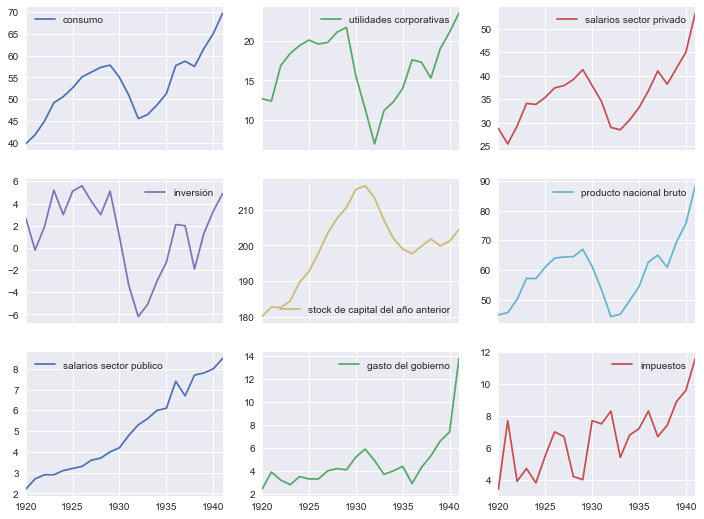

In [3]:
datanames = dict(C="consumo",
                 P="utilidades corporativas",
                 Wp="salarios sector privado",
                 I="inversión",
                 K1="stock de capital del año anterior",
                 X="producto nacional bruto",
                 Wg="salarios sector público",
                 G="gasto del gobierno",
                 T="impuestos")

klein.rename(columns=datanames).plot(subplots=True, figsize=[12,9], layout=[-1,3]);

## Series adicionales

La variable `K1` en la base de datos corresponde al *rezago* del capital, por lo que generamos `K`. Además, generamos la tendencia y el intercepto.

In [4]:
#klein['K'] = klein['K1'].shift(-1)
klein['A'] = np.arange(klein.shape[0]) - 11
klein['interc'] = 1

Generamos las variables predeterminadas y la suma de salarios

In [5]:
klein['P1'] = klein['P'].shift(1)
klein['X1'] = klein['X'].shift(1)
klein['W'] = klein['Wp'] + klein['Wg']

In [6]:
klein.dropna(inplace=True)

## Preparando las regresiones

Luego clasificamos las variables en tres grupos: endógenas, exogenas, y predeterminadas

In [7]:
endogenas = ['C', 'I', 'Wp', 'X', 'P']
exogenas = ['interc', 'G', 'T', 'Wg', 'A']
predeterminadas = ['K1', 'P1', 'X1']

regresores_eqs = [['interc', 'P', 'P1', 'W'], ['interc', 'P', 'P1', 'K1'], ['interc', 'X', 'X1', 'A']]

## Etapa 1: regresión de las endógenas contra todas las exógenas del sistema

In [8]:
Y = klein[endogenas]
X = klein[exogenas+predeterminadas]

In [9]:
beta = np.linalg.solve(X.T@X, X.T@Y)
beta = pd.DataFrame(beta, columns=endogenas, index=exogenas+predeterminadas)

In [10]:
yhat = X@beta

## Preparar datos para la segunda etapa

Definir lista de instrumentos para cada ecuación: 

Esta lista es igual a la lista de regresores original, pero sustituyendo las endógenas por su valor ajustado de la etapa 1

In [11]:
klein_ols = pd.concat([yhat, klein[exogenas+predeterminadas]], axis=1)
klein_ols['W'] = klein_ols['Wp'] + klein_ols['Wg']

## Etapa 2

In [12]:
coef2sls = []
for xx, yy in zip(regresores_eqs, endogenas[:3]):
    X1, y1 = klein_ols[xx], klein_ols[yy]
    beta1 = np.linalg.solve(X1.T@X1, X1.T@y1)
    coef2sls.append(pd.Series(beta1.ravel(), index=xx, name=yy))
pd.concat(coef2sls, axis=1, sort=False).round(3)

,C,I,Wp
interc,16.555,20.278,1.500
P,0.017,0.150,NaN
P1,0.216,0.616,NaN
W,0.810,NaN,NaN
K1,NaN,-0.158,NaN
X,NaN,NaN,0.439
X1,NaN,NaN,0.147
A,NaN,NaN,0.130


## Mismo modelo, pero usando statsmodels

In [13]:
from statsmodels.sandbox.regression.gmm import IV2SLS

In [14]:
for xx, yy in zip(regresores_eqs, endogenas[:3]):
    fit = IV2SLS(klein[yy], klein[xx], instrument=X).fit()
    print(fit.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                      C   R-squared:                       0.977
Model:                         IV2SLS   Adj. R-squared:                  0.973
Method:                     Two Stage   F-statistic:                     225.9
                        Least Squares   Prob (F-statistic):           6.82e-14
Date:                Sat, 18 Dec 2021                                         
Time:                        13:52:01                                         
No. Observations:                  21                                         
Df Residuals:                      17                                         
Df Model:                           3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
interc        16.5548      1.468     11.277      0.0

## Mismo modelo, pero usando fórmulas de statsmodels, etapa por etapa

In [15]:
import statsmodels.formula.api as smf

In [16]:
rhs = ' + '.join(exogenas+predeterminadas)

In [17]:
klein_stage1 = klein.copy()

In [18]:
for y in endogenas:
    klein_stage1[y] = smf.ols(f'{y} ~ {rhs}', data=klein).fit().fittedvalues
klein_stage1.eval('W=Wp+Wg', inplace=True)

In [19]:
regresores_eqs = ['P + P1 + W',
                  'P + P1 + K1',
                  'X + X1 + A']

In [20]:
for xx, yy in zip(regresores_eqs, endogenas[:3]):
    print(f'\nRegresión para {yy}\n')
    print(smf.ols(f'{yy} ~ {xx}', data=klein_stage1).fit().params)


Regresión para C

Intercept    16.554756
P             0.017302
P1            0.216234
W             0.810183
dtype: float64

Regresión para I

Intercept    20.278209
P             0.150222
P1            0.615944
K1           -0.157788
dtype: float64

Regresión para Wp

Intercept    1.500297
X            0.438859
X1           0.146674
A            0.130396
dtype: float64
